I finished the [Data Management and Visualisation course](https://www.coursera.org/learn/data-management-visualization/home/welcome) on coursera with full marks on [this post](http://lilithelina.tumblr.com/post/130899449414/data-visualisation-python), and am now finally continuing with the follow-up course, [Data Analysis Tools](https://www.coursera.org/learn/data-analysis-tools/), for which I will, of course, also use my **Breast Cancer Causes Internet Usage!** (BCCIU) project. As a short reminder: [I'm working with](http://lilithelina.tumblr.com/post/128347327089/choice-of-data) the [Gapminder](http://www.gapminder.org/) data set, analysing the relationships between new breast cancer cases per 100,000 women in 2002 and internet use rates in 2010 or female employment rates in 2007, respectively.  
As before, the output will look lots better in the [nbviewer](http://nbviewer.ipython.org/github/LilithElina/Data-Analysis-and-Interpretation/tree/master/DataAnaT/Week%20One%20-%20ANOVA.ipynb) than on tumblr.

First up comes some of the code I created before, including a summary figure for your information.

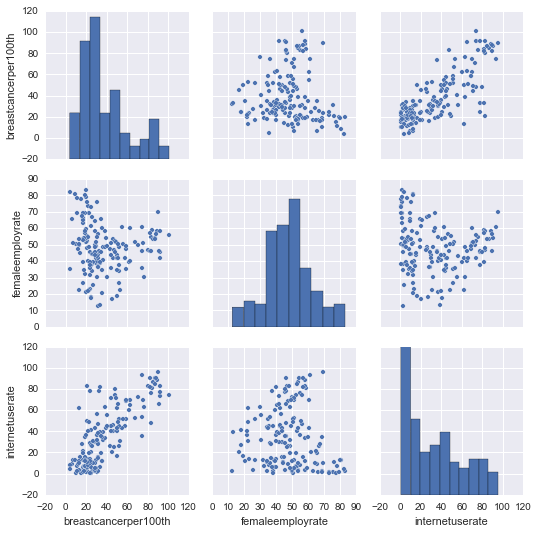

In [1]:
# activate inline plotting, should be first statement
%matplotlib inline

# load packages
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf       # for ANOVA
import statsmodels.stats.multicomp as multi # for post hoc test 
import warnings                             # ignore warnings (e.g. from future, deprecation, etc.)
warnings.filterwarnings('ignore')           # for layout reasons, after I read and acknowledged them all!

# read in data
data = pandas.read_csv("../gapminder.csv", low_memory=False)

# subset the data and make a copy to avoid error messages later on
sub = data[["country", "breastcancerper100th", "femaleemployrate", "internetuserate"]]
sub_data = sub.copy()

# change data types to numeric
sub_data["breastcancerper100th"] = sub_data["breastcancerper100th"].convert_objects(convert_numeric=True)
sub_data["femaleemployrate"] = sub_data["femaleemployrate"].convert_objects(convert_numeric=True)
sub_data["internetuserate"] = sub_data["internetuserate"].convert_objects(convert_numeric=True)

# remove rows with missing values (copy again)
sub2 = sub_data.dropna()
sub_data2 = sub2.copy()

# plot comprehensive pair plot of subsetted data
#semicolon hides text output of matplotlib
seaborn.pairplot(sub_data2);

In the plot above, you can see the distributions of my variables of interest as histograms on the diagonal, and scatterplots of their relationships with each other in the other fields. Most striking is the linear relationship between breast cancer and internet usage - hence the BCCIU slogan. During the evaluation of my final visualisation post, I was asked why I'm not saying that internet usage causes breast cancer, but instead state something stupid (my own words) like breast cancer causes internet usage. The reason is simple - the breast cancer data is from 2002, the internet usage data, on the other hand, is from 2010. Since I haven't seen [re-annual plants](https://en.wikipedia.org/wiki/Flora_and_fauna_of_the_Discworld#Re-annual_plant) in this world yet, I don't believe that such a backwards causation can exist, and since I don't have data for both variables from the same year, or the opposite of what I have, I'm sticking to my topic.

In the first week of the [Data Analysis](https://www.coursera.org/learn/data-analysis-tools/) course, we're using ANOVA (**an**alysis **o**f **va**riance) and Tukey's HSD (**h**onest **s**ignificant **d**ifference) test to check for significant differences in mean values of different groups. This means that we're comparing quantitative and categorical data - which means I need a categorical explanatory variable. Therefore, I'm splitting the breast cancer data into its quartiles (four equal sized groups).

breast cancer cases per 100,000 females - quartiles
50th     40
75th     40
25th     41
100th    41
Name: breastquart, dtype: int64


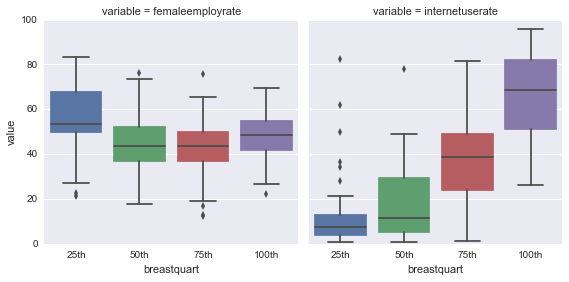

In [2]:
# quartile split (use qcut function & ask for 4 groups)
print('breast cancer cases per 100,000 females - quartiles')
sub_data2['breastquart'] = pandas.qcut(sub_data2.breastcancerper100th, 4, labels=["25th", "50th", "75th", "100th"])
sub_data2['breastquart'] = sub_data2.breastquart.astype(numpy.object) # convert to a data type smf.ols() can understand
print(sub_data2['breastquart'].value_counts(sort=False))

# "melt" the data into better (long) format for factorplot()
sub_data2.m = pandas.melt(sub_data2, id_vars=["breastquart"], value_vars=["femaleemployrate", "internetuserate"])

# plot (setting order manually to avoid weird automatic order)
seaborn.factorplot(x='breastquart', y='value', col="variable", data=sub_data2.m,
                   kind="box", ci=None, x_order=["25th", "50th", "75th", "100th"]);

Great, four (almost) equal sized groups! And the boxplots show the linear relationship between breast cancer and internet usage, and only a hinted half-circle relation between breast cancer and female employment - just as expected.  
What we want to do now is check if the means of the values differ between the different quartiles, either for the female employment rate or the internet usage rate. Of course, testing only differences in means doesn't mean much if the variance within a group is very large. That is where ANOVA - the analysis of variance - comes in. This method can tell us if the variance within a group is small enough for the variance between two groups to be significant (i.e. "Can I trust this difference between my groups?"). Before we test that, though, let's have a look at the actual means and standard deviations of the data!

In [3]:
# calculate and print means for only the two interesting variables in the breast cancer groups
print ("means for female employment and internet usage by breast cancer quartiles")
print(sub_data2.groupby("breastquart")["femaleemployrate", "internetuserate"].mean())

# calculate and print standard deviations for only the two interesting variables in the breast cancer groups
print ("\n\nstandard deviations for female employment and internet usage by breast cancer quartiles")
print(sub_data2.groupby("breastquart")["femaleemployrate", "internetuserate"].std())

means for female employment and internet usage by breast cancer quartiles
             femaleemployrate  internetuserate
breastquart                                   
100th               47.531707        65.645802
25th                56.148780        13.583038
50th                44.407500        17.851427
75th                42.630000        38.971075


standard deviations for female employment and internet usage by breast cancer quartiles
             femaleemployrate  internetuserate
breastquart                                   
100th               10.192631        18.686857
25th                16.156842        17.237897
50th                15.217860        16.590912
75th                13.342091        21.744734


Not surprisingly, we can see quite an increase in means for internet usage over the breast cancer quartiles (please note the somewhat irritating order of the quartiles!), while the female employment rate shows less pronounced differences. Can these still be significant?

To test for significance (ANOVA), we're using a function called `ols()` (**o**rdinary **l**east **s**quares) from the `statsmodels.formula.api` package. OLS is a powerful [linear regression method](https://en.wikipedia.org/wiki/Ordinary_least_squares) about which we will apparently learn in a later course.

In [4]:
# using ols() function for calculating the F-statistic and associated p-value
breast_inet_m = smf.ols(formula='internetuserate ~ C(breastquart)', data=sub_data2)
breast_inet_r = breast_inet_m.fit()
print ("breast cancer versus internet usage\n", breast_inet_r.summary())

breast_empl_m = smf.ols(formula='femaleemployrate ~ C(breastquart)', data=sub_data2)
breast_empl_r = breast_empl_m.fit()
print ("\n\nbreast cancer versus female employment\n", breast_empl_r.summary())

breast cancer versus internet usage
                             OLS Regression Results                            
Dep. Variable:        internetuserate   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     66.58
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           6.92e-28
Time:                        08:52:15   Log-Likelihood:                -701.94
No. Observations:                 162   AIC:                             1412.
Df Residuals:                     158   BIC:                             1424.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------

The `ols()` function returns a lot of results (and the warning also seems to be a standard), but for now we'll only look at the [*F-statistic*](https://en.wikipedia.org/wiki/Analysis_of_variance#The_F-test) and the *Prob (F-statistic)*. For breast cancer versus internet usage, the `F-statistic = 66.58` -- this is the result of dividing the variance between groups by the variance within groups. The higher the number, therefore, the higher is the variance between groups compared to the variance within groups, so this value is pretty good. Accordingly, the probability that we could see this value simply by chance is very low (`p < 0.0001`).  
The comparison of breast cancer versus female employment, on the other hand, shows a lower F-statistic of `7.562`. Nevertheless, the *p*-value is still below the common threshold of `0.05` that is mostly used in science (`p = 0.0000928`). This means that, according to the ANOVA/OLS, the difference between groups is also significant in this comparison.

The problem we have now, with the ANOVA results, is that they don't tell us which groups differ significantly from each other. Seeing ANOVA as a hypothesis test, we'd say that the null hypothesis is "all means are equal", while the alternative hypothesis is simply "not all means are equal". While we know now that there are significant differences in the data, we still don't know which group's means are (significantly) not equal. To figure that out, we need a *post hoc* test like [Tukey's HSD](https://en.wikipedia.org/wiki/Tukey's_range_test) test.

In [5]:
# do multiple comparisons and Tukey HSD
breast_inet_mc = multi.MultiComparison(sub_data2['internetuserate'], sub_data2['breastquart'])
breast_inet_rc = breast_inet_mc.tukeyhsd()
print("breast cancer versus internet usage\n", breast_inet_rc.summary())

breast_empl_mc = multi.MultiComparison(sub_data2['femaleemployrate'], sub_data2['breastquart'])
breast_empl_rc = breast_empl_mc.tukeyhsd()
print("\n\nbreast cancer versus female employment\n", breast_empl_rc.summary())

breast cancer versus internet usage
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
100th   25th  -52.0628 -62.7661 -41.3594  True 
100th   50th  -47.7944 -58.5644 -37.0243  True 
100th   75th  -26.6747 -37.4448 -15.9047  True 
 25th   50th   4.2684  -6.5017  15.0384  False 
 25th   75th   25.388   14.618  36.1581   True 
 50th   75th  21.1196  10.2833   31.956   True 
-----------------------------------------------


breast cancer versus female employment
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
100th   25th   8.6171   0.6393  16.5948  True 
100th   50th  -3.1242  -11.1517  4.9033 False 
100th   75th  -4.9017  -12.9292  3.1258 False 
 25th   50th  -11.7413 -19.7688 -3.7138  True 
 25th   75th  -13.5188 -21.5463 -5.4913  True 
 50th   75th  -1.7775  -9.8544   6.2994 False 
-----------

This has much less output than the OLS. In the headline, we are told which kind of test was used (Tukey HSD) and how the [multiple comparison problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) was corrected.

> In case you don't know what I'm talking about: when we do a single statistical test that returns a *p*-value, this *p*-value tells us how likely it is that we were wrong in rejecting our null hypothesis. Usually, you hope for `p < 0.05`, or less than 5% - meaning a 5% chance of making a type I error (rejecting the null hypothesis even though it is true). I'll skip the math here and try with common sense instead: the more tests you do on subsets of your data, the higher are your chances to find some random effect - for only four tests, the probability of making at least one mistake is already `0.185` and not `0.05` or below any more. This is called the **f**amily **w**ise **e**rror **r**ate, or [FWER](https://en.wikipedia.org/wiki/Familywise_error_rate) - the probability of making at least one mistake (i.e. type I error).

The result summary printed above shows that the FWER was taken into account automatically, and then lists all the group-wise comparisons, their differences, and whether or not we can reject the null hypothesis (that both groups have equal means).

For the breast cancer versus internet usage comparison - my main topic -, all quartiles have significantly different means, except the 25th and 50th. From a statistics point of view, it's quite safe to say that there is a significant difference in the internet use rates for different groups of new breast cancer cases, with `F(3, 158) = 66.58` (the numbers in brackets are [degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_%28statistics%29), df model and df residuals, from the ANOVA summary above) and `p < 0.0001`. Additionally, the *post hoc* test revealed that countries with more breast cancer cases also show significantly higher internet use rates (except when comparing the first two quartiles).

The means of female employment rates, when looking at the same breast cancer quartiles, are also significantly different: `F(3, 158) = 7.562`, `p < 0.0001`. Interestingly, here it is only the 25th quartile that shows significantly higher female employment rates (56.15% &plusmn; 16.16) than the other quartiles. Apparently, significantly more women were working (in 2007) in countries with only few breast cancer cases (as of 2002) than in countries with higher breast cancer discovery rates.

Ignoring "corrleation does not mean causation", we can now imply that breast cancer indeed causes internet usage (people looking for help and information), and that it also leads to lower female employment rates (because women with cancer don't go to work). [Tada](http://de.urbandictionary.com/define.php?term=tada)!